# Combined Emission Models

In the previous pages we show how to construct emission models which contain strictly stellar **or** AGN emission.
However, we can define models that combine the emission from stars **and** AGN to produce "galaxy level" emission.
To do so, we simply provide the emitter based models to a combination model with the "galaxy" emitter type.

As an example, let's create a ``BimodalPacmanEmission`` model and combine it with a ``UnifiedAGN`` model, with attenuation and dust emission.

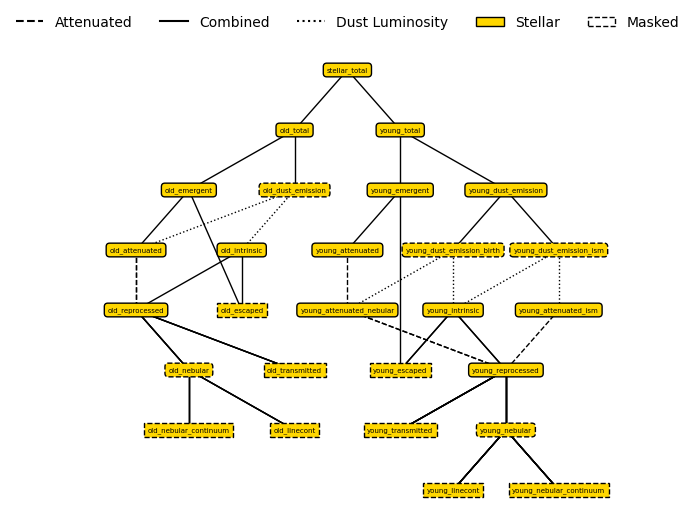

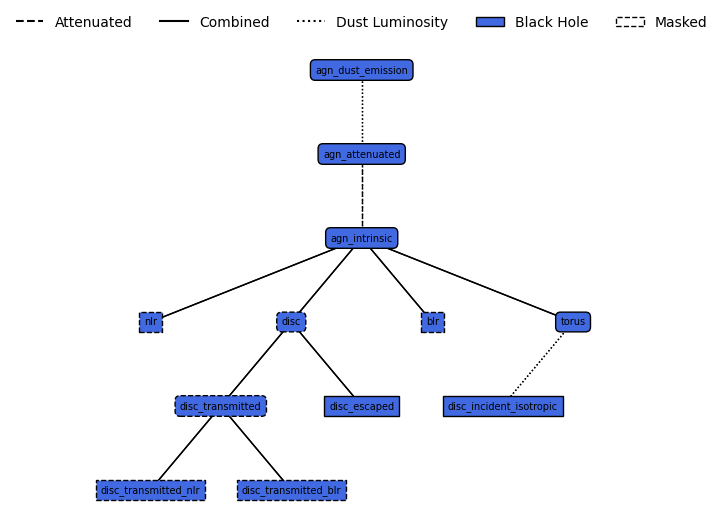

(<Figure size 600x600 with 1 Axes>, <Axes: >)

In [1]:
from unyt import kelvin

from synthesizer.emission_models import (
    AttenuatedEmission,
    BimodalPacmanEmission,
    DustEmission,
    EmissionModel,
    UnifiedAGN,
)
from synthesizer.emission_models.attenuation import PowerLaw
from synthesizer.emission_models.dust.emission import Blackbody, Greybody
from synthesizer.grid import Grid

# Get the grids which we'll need for extraction
grid_dir = "../../../tests/test_grid"
grid_name = "test_grid"
grid = Grid(grid_name, grid_dir=grid_dir)
nlr_grid = Grid("test_grid_agn-nlr", grid_dir="../../../tests/test_grid")
blr_grid = Grid("test_grid_agn-blr", grid_dir="../../../tests/test_grid")

# Get the stellar pacman model
pc_model = BimodalPacmanEmission(
    grid=grid,
    tau_v_ism=1.0,
    tau_v_birth=0.7,
    dust_curve_ism=PowerLaw(slope=-1.3),
    dust_curve_birth=PowerLaw(slope=-0.7),
    dust_emission_ism=Blackbody(temperature=100 * kelvin),
    dust_emission_birth=Blackbody(temperature=30 * kelvin),
    fesc=0.2,
    fesc_ly_alpha=0.9,
    label="stellar_total",
)
pc_model.plot_emission_tree(fontsize=5)

# Get the UnifiedAGN model
uni_model = UnifiedAGN(
    nlr_grid,
    blr_grid,
    covering_fraction_nlr=0.1,
    covering_fraction_blr=0.1,
    torus_emission_model=Blackbody(1000 * kelvin),
    label="agn_intrinsic",
)

# Define an emission model to attenuate the intrinsic AGN emission
att_uni_model = AttenuatedEmission(
    dust_curve=PowerLaw(slope=-1.0),
    apply_dust_to=uni_model,
    tau_v=0.7,
    emitter="blackhole",
    label="agn_attenuated",
)

# And now include the dust emission
dust_uni_model = DustEmission(
    dust_emission_model=Greybody(30 * kelvin, 1.2),
    dust_lum_intrinsic=uni_model,
    dust_lum_attenuated=att_uni_model,
    emitter="blackhole",
    label="agn_dust_emission",
)
dust_uni_model.plot_emission_tree(fontsize=7)

Now that we have the emission models for each individual galaxy component we can combine them to make our galaxy level model.
First, let's make one that will give the combined intrinsic emission (the emission before dust attenuation).

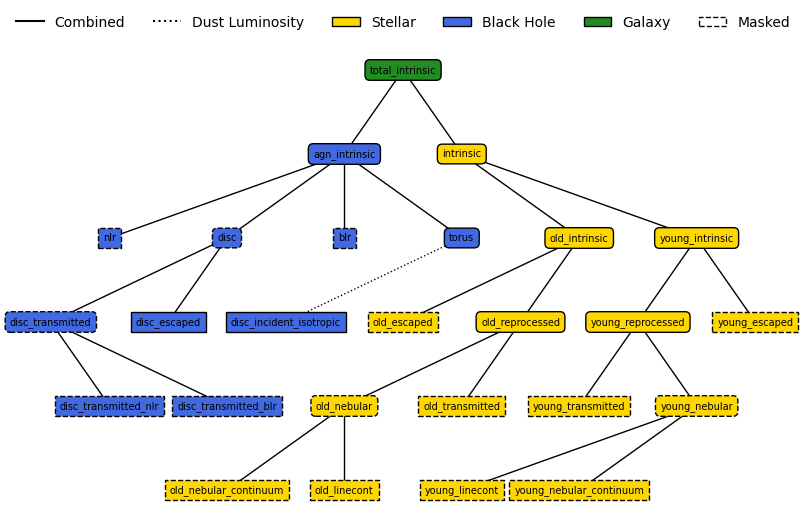

(<Figure size 1000x600 with 1 Axes>, <Axes: >)

In [2]:
gal_intrinsic = EmissionModel(
    label="total_intrinsic",
    combine=(uni_model, pc_model["intrinsic"]),
    emitter="galaxy",
)
gal_intrinsic.plot_emission_tree(fontsize=7, figsize=(10, 6))

And one for the attenuated emission (where we'll include the intrinsic model as a related model).

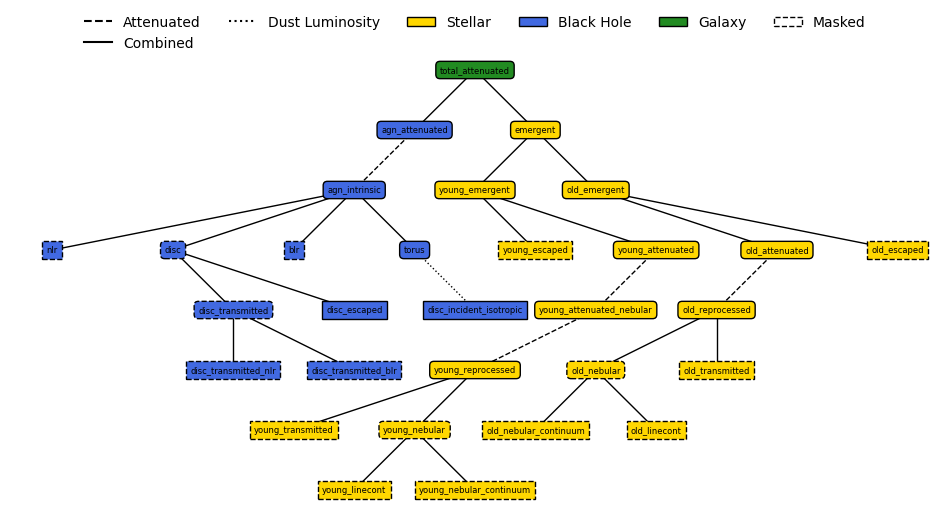

(<Figure size 1200x600 with 1 Axes>, <Axes: >)

In [3]:
gal_attenuated = EmissionModel(
    label="total_attenuated",
    combine=(att_uni_model, pc_model["emergent"]),
    related_models=(gal_intrinsic,),
    emitter="galaxy",
)
gal_attenuated.plot_emission_tree(fontsize=6, figsize=(12, 6))

We can then create a dust emission model for the whole galaxy based on the combined attenuated and intrinsic emission.

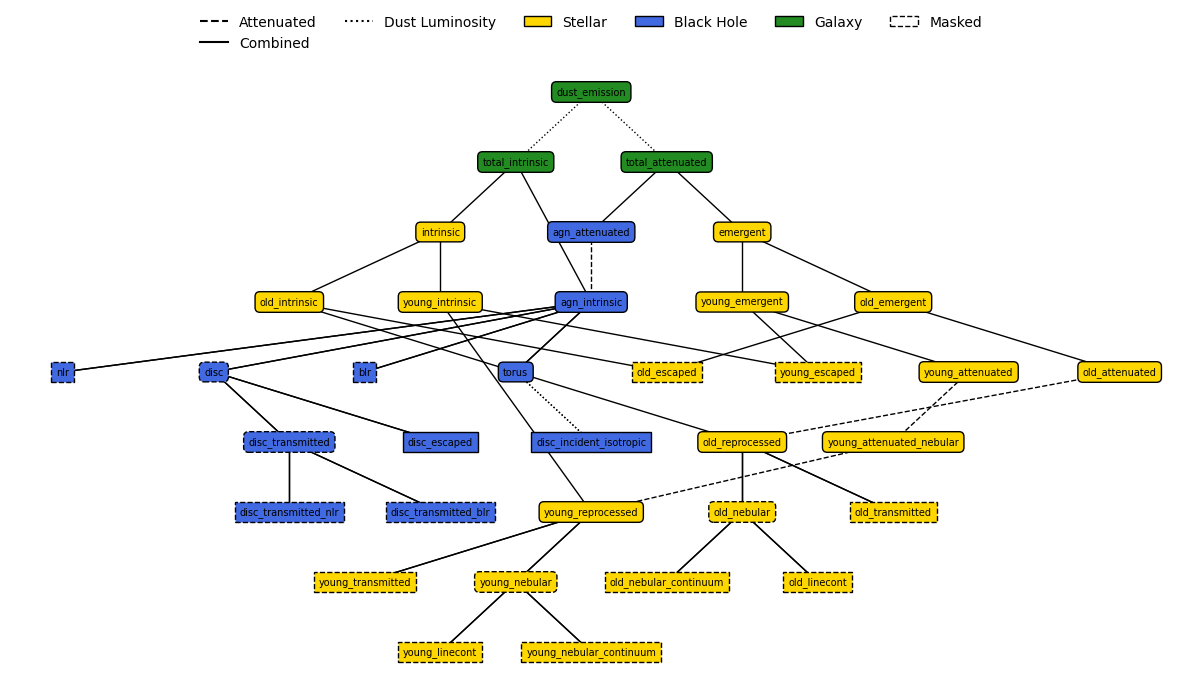

(<Figure size 1500x800 with 1 Axes>, <Axes: >)

In [4]:
dust_emission = DustEmission(
    dust_emission_model=Greybody(100 * kelvin, 1.2),
    dust_lum_intrinsic=gal_intrinsic,
    dust_lum_attenuated=gal_attenuated,
    emitter="galaxy",
    label="dust_emission",
)
dust_emission.plot_emission_tree(fontsize=7, figsize=(15, 8))

And finally we can combine the emissions into the total emission of the galaxy.

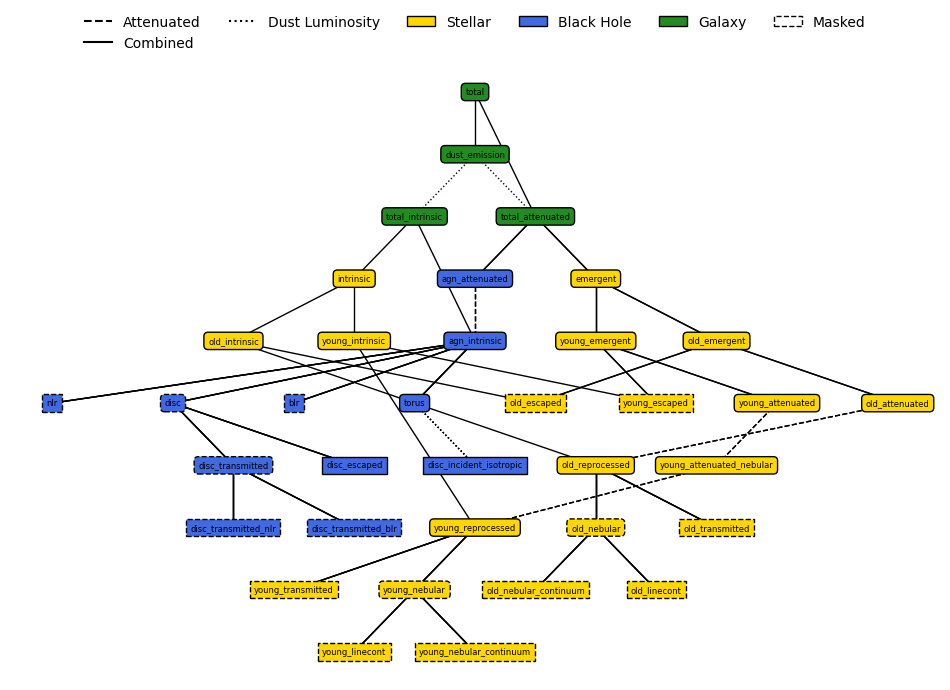

(<Figure size 1200x800 with 1 Axes>, <Axes: >)

In [5]:
total = EmissionModel(
    label="total",
    combine=(dust_emission, gal_attenuated),
    emitter="galaxy",
)
total.plot_emission_tree(fontsize=6, figsize=(12, 8))

## Combining integrated and per particle emission

You may want to have a model with per particle emission for the components and integrated emission for the galaxy (since per particle emission is nonsensical when talking about the combined emission from the whole galaxy). This can be achieved either by passing ``per_particle=True`` at instantiation of the component level models (see the [usage section](model_usage.ipynb)) or by calling the setter method:

In [6]:
total.set_per_particle(True)

Calling this setter method will set all child models to have per_particle=True while respecting that galaxy level models should have per_particle=False. We can see this in the emission model plot.

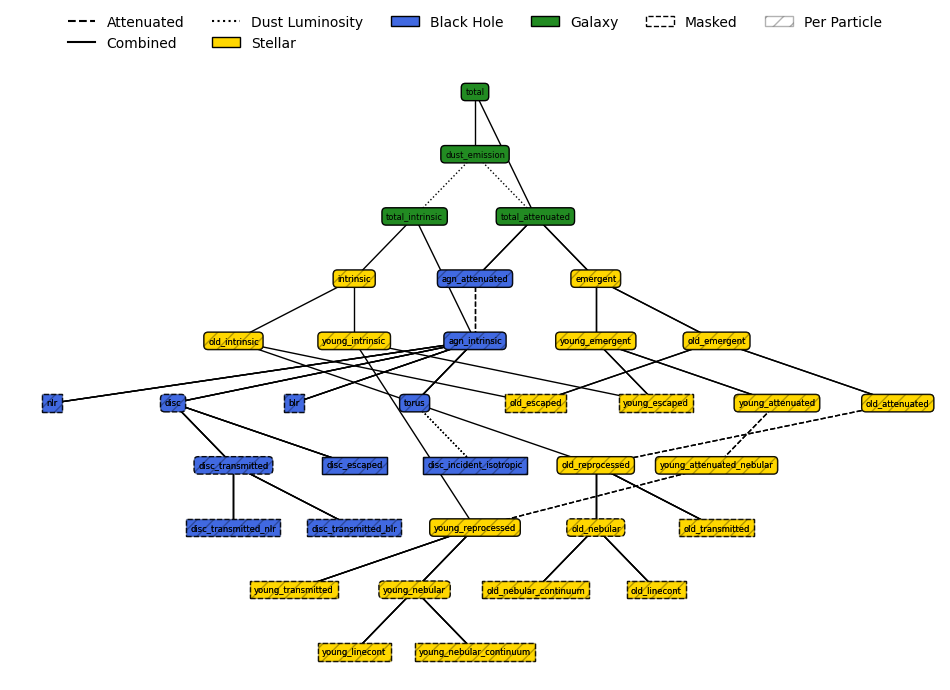

(<Figure size 1200x800 with 1 Axes>, <Axes: >)

In [7]:
total.plot_emission_tree(fontsize=6, figsize=(12, 8))